## Random Forest Model

### Setup

In [5]:
# import dependencies
import os
import random
import time
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import torch
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights

import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [6]:
# CONFIGURATIONS
TRAIN_TSV = '../data/fakeddit_train.tsv'
VAL_TSV = '../data/fakeddit_val.tsv'
TEST_TSV = '../data/fakeddit_test.tsv'
IMG_DIR = '../data/images/'
LABELS = [0, 1, 2]
LABEL_NAMES = ['True', 'Misleading', 'Fake']
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42

# set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

In [7]:
# load datasets
train_df = pd.read_csv(TRAIN_TSV, sep='\t')
val_df = pd.read_csv(VAL_TSV, sep='\t')
test_df = pd.read_csv(TEST_TSV, sep='\t')

In [8]:
# class weighting due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {np.int64(0): np.float64(0.6041841841841842), np.int64(1): np.float64(9.280135301353013), np.int64(2): np.float64(0.8083299852685149)}


### Feature Extraction

In [9]:
# text feature extraction 
tfidf = TfidfVectorizer(max_features=5000)

X_text_train = tfidf.fit_transform(train_df['clean_title']).toarray()
X_text_val = tfidf.transform(val_df['clean_title']).toarray()
X_text_test = tfidf.transform(test_df['clean_title']).toarray()

In [12]:
# image feature extraction
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# use pretrained ResNet18 without final FC
cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
cnn = torch.nn.Sequential(*list(cnn.children())[:-1])
cnn.eval()
cnn.to(DEVICE)

def extract_img_features(img_id):
    img_path = os.path.join(IMG_DIR, f"{img_id}.jpg")
    if not os.path.exists(img_path):
        return np.zeros(512, dtype=np.float32)
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feat = cnn(img).squeeze().cpu().numpy()
    return feat

# precompute image features
X_img_train = np.array([extract_img_features(id_) for id_ in train_df['id']])
X_img_val = np.array([extract_img_features(id_) for id_ in val_df['id']])
X_img_test = np.array([extract_img_features(id_) for id_ in test_df['id']])

In [13]:
# metadata feature extraction
meta_cols = ['num_comments', 'score', 'upvote_ratio']  

if all(col in train_df.columns for col in meta_cols):
    X_meta_train = train_df[meta_cols].to_numpy()
    X_meta_val = val_df[meta_cols].to_numpy()
    X_meta_test = test_df[meta_cols].to_numpy()
else:
    X_meta_train = X_meta_val = X_meta_test = np.zeros((len(train_df), 0))

### Combine Features

In [14]:
X_train = np.concatenate([X_text_train, X_img_train, X_meta_train], axis=1)
X_val = np.concatenate([X_text_val, X_img_val, X_meta_val], axis=1)
X_test = np.concatenate([X_text_test, X_img_test, X_meta_test], axis=1)

y_train = train_df['3_way_label'].to_numpy()
y_val = val_df['3_way_label'].to_numpy()
y_test = test_df['3_way_label'].to_numpy()

### Train Random Forest Classifier

In [12]:
# define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# define model
rf = RandomForestClassifier(
    class_weight=class_weights_dict,
    random_state=SEED,
    n_jobs=-1
)

In [13]:
# tune hyperparameters
print("Starting Grid Search...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

end_time = time.time()

print(f"\nGrid search complete in {(end_time - start_time)/60:.2f} minutes.")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Macro-F1: {grid_search.best_score_:.4f}")

Starting Grid Search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Grid search complete in 28.09 minutes.
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Macro-F1: 0.6446


### Evaluation

In [15]:
# fit best random forest model
best_rf = RandomForestClassifier(
    class_weight=class_weights_dict,
    random_state=SEED,
    n_jobs=-1, 
    max_depth=10,
    max_features="sqrt",
    min_samples_leaf=2, 
    min_samples_split=2, 
    n_estimators=200
)
best_rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# evaluate on validation set
y_val_pred = best_rf.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')
print("\nEvaluation on Validation Set")
print(f"Validation Accuracy: {acc_val:.4f}")
print(f"Validation Macro-F1: {f1_val_macro:.4f}")
print(f"Validation Weighted F1: {f1_val_weighted:.4f}")


Evaluation on Validation Set
Validation Accuracy: 0.6938
Validation Macro-F1: 0.6471
Validation Weighted F1: 0.6908


In [17]:
# print classification report
print("=== Validation Classification Report (Random Forest) ===\n")
print(classification_report(y_val, y_val_pred, target_names=LABEL_NAMES, digits=4))

=== Validation Classification Report (Random Forest) ===

              precision    recall  f1-score   support

        True     0.7239    0.7862    0.7537      2081
  Misleading     0.5057    0.6544    0.5705       136
        Fake     0.6677    0.5736    0.6171      1555

    accuracy                         0.6938      3772
   macro avg     0.6324    0.6714    0.6471      3772
weighted avg     0.6928    0.6938    0.6908      3772



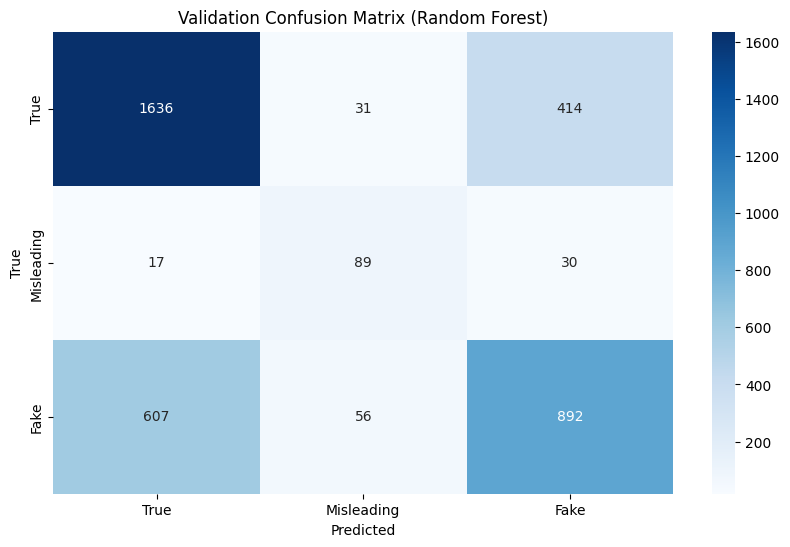

In [18]:
# plot confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix (Random Forest)')
plt.show()

In [19]:
# evaluate on test set
y_test_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
f1_test_macro = f1_score(y_test, y_test_pred, average='macro')
f1_test_weighted = f1_score(y_test, y_test_pred, average='weighted')
print("\nEvaluation on Test Set")
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test Macro-F1: {f1_test_macro:.4f}")
print(f"Test Weighted F1: {f1_test_weighted:.4f}")


Evaluation on Test Set
Test Accuracy: 0.6920
Test Macro-F1: 0.6347
Test Weighted F1: 0.6886


In [20]:
# print classification report
print("=== Test Classification Report (Random Forest) ===\n")
print(classification_report(y_test, y_test_pred, target_names=LABEL_NAMES, digits=4))

=== Test Classification Report (Random Forest) ===

              precision    recall  f1-score   support

        True     0.7218    0.7901    0.7544      2082
  Misleading     0.5000    0.5778    0.5361       135
        Fake     0.6637    0.5707    0.6137      1556

    accuracy                         0.6920      3773
   macro avg     0.6285    0.6462    0.6347      3773
weighted avg     0.6899    0.6920    0.6886      3773



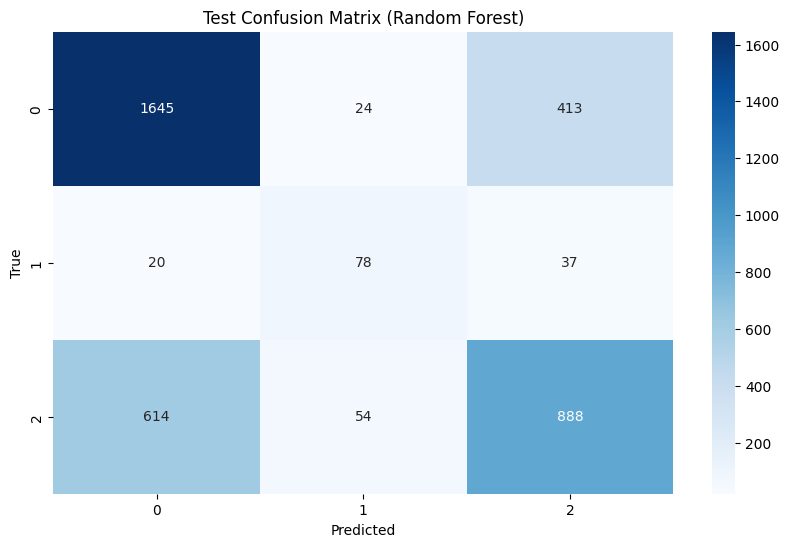

In [21]:
# plot confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix (Random Forest)')
plt.show()

In [27]:
# get probabilities
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)

# binarize for roc and precision-recall plots
y_true_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

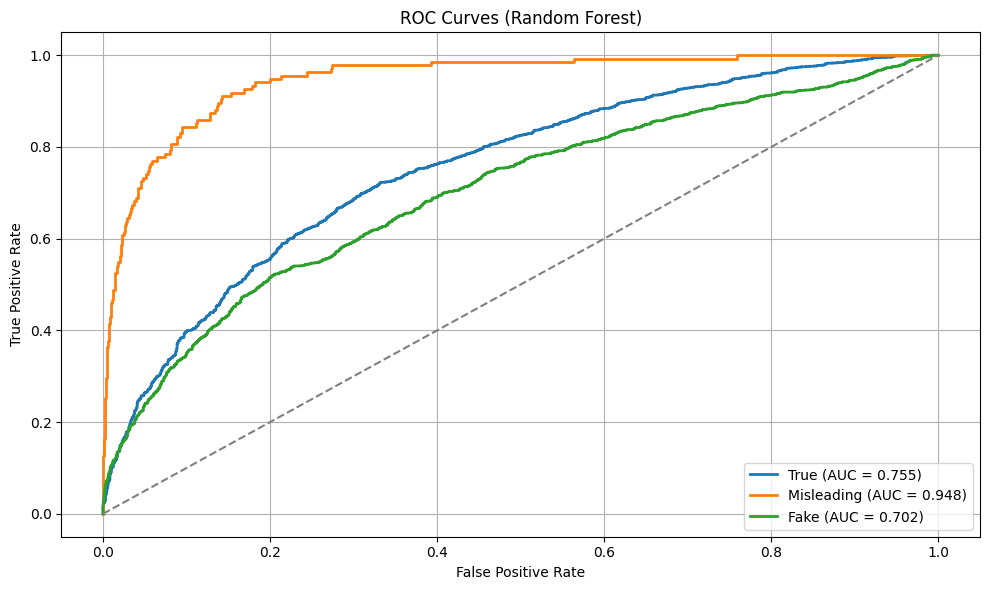

In [30]:
# plot ROC curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(LABEL_NAMES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

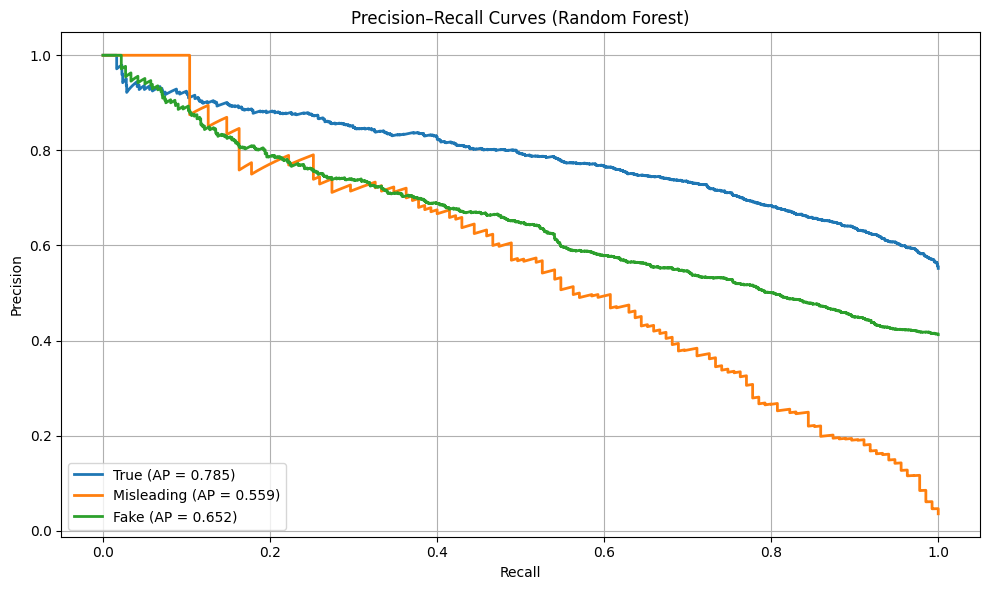

In [32]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_test_proba[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_test_proba[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(LABEL_NAMES):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Random Forest)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 1162 / 3773


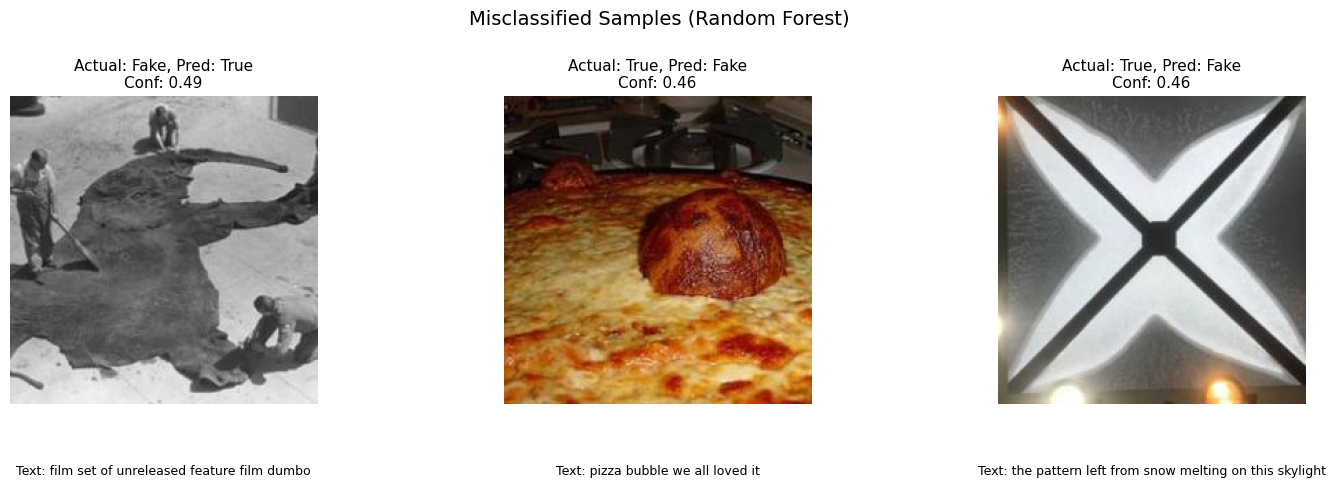

In [36]:
# get misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_test_pred)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(y_test)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = LABEL_NAMES[y_test[sample_idx]]
    pred_label = LABEL_NAMES[y_test_pred[sample_idx]]
    probs = y_test_proba[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (Random Forest)", fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Feature Importance

In [ ]:
# combine feature names
text_feature_names = tfidf.get_feature_names_out()
img_feature_names = [f"img_feat_{i}" for i in range(X_img_train.shape[1])]
meta_feature_names = meta_cols if len(meta_cols) > 0 else []
feature_names = np.concatenate([text_feature_names, img_feature_names, meta_feature_names])

# convert numpy array to dataframe
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# get SHAP explainer object
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_df)

C:\Users\Isabella\AppData\Local\Temp\ipykernel_20940\2618459137.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0], X_test_df, feature_names=feature_names, show=True)


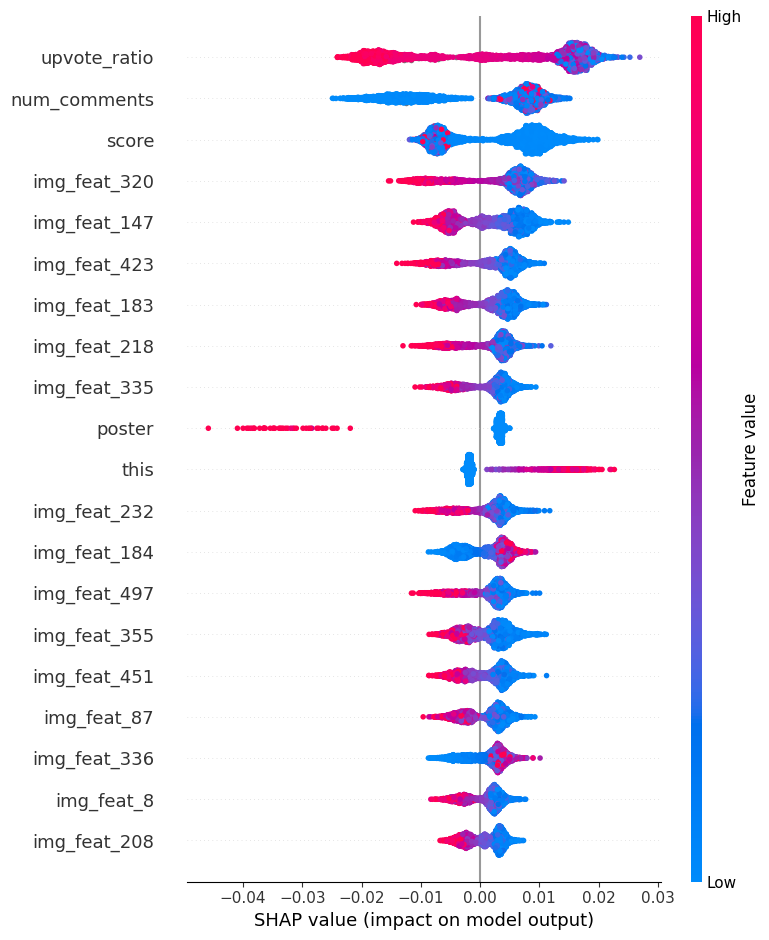

In [36]:
# SHAP summary plot for class 0 (true)
shap.summary_plot(shap_values[:, :, 0], X_test_df, feature_names=feature_names, show=True)

C:\Users\Isabella\AppData\Local\Temp\ipykernel_20940\603804064.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test_df, feature_names=feature_names, show=True)


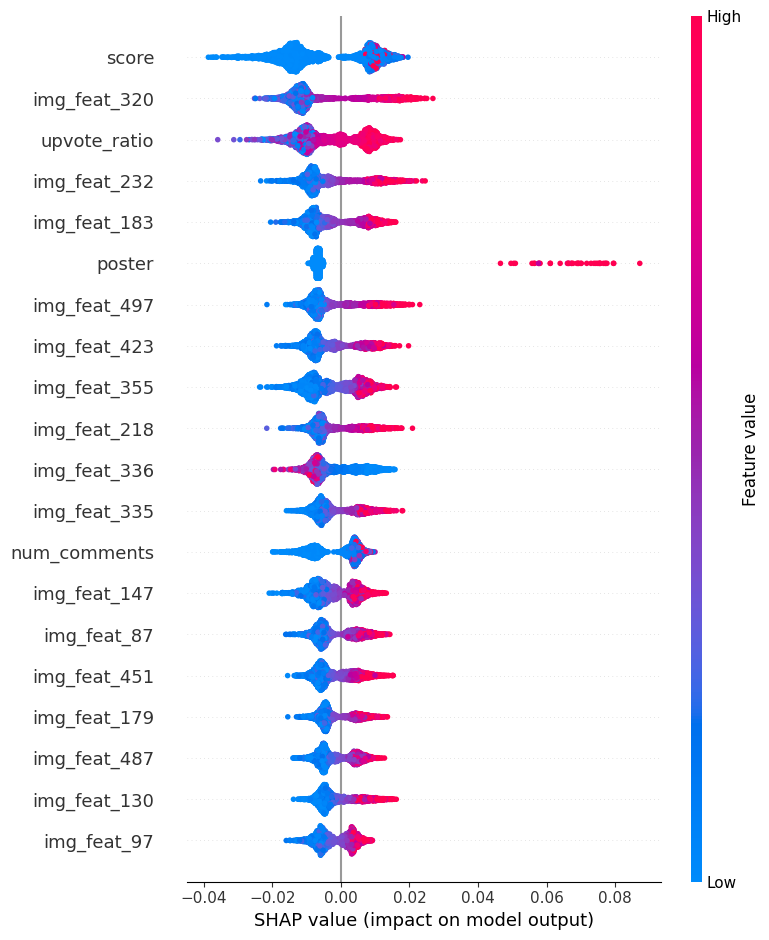

In [37]:
# SHAP summary plot for class 1 (misleading)
shap.summary_plot(shap_values[:, :, 1], X_test_df, feature_names=feature_names, show=True)

C:\Users\Isabella\AppData\Local\Temp\ipykernel_20940\1241336571.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 2], X_test_df, feature_names=feature_names, show=True)


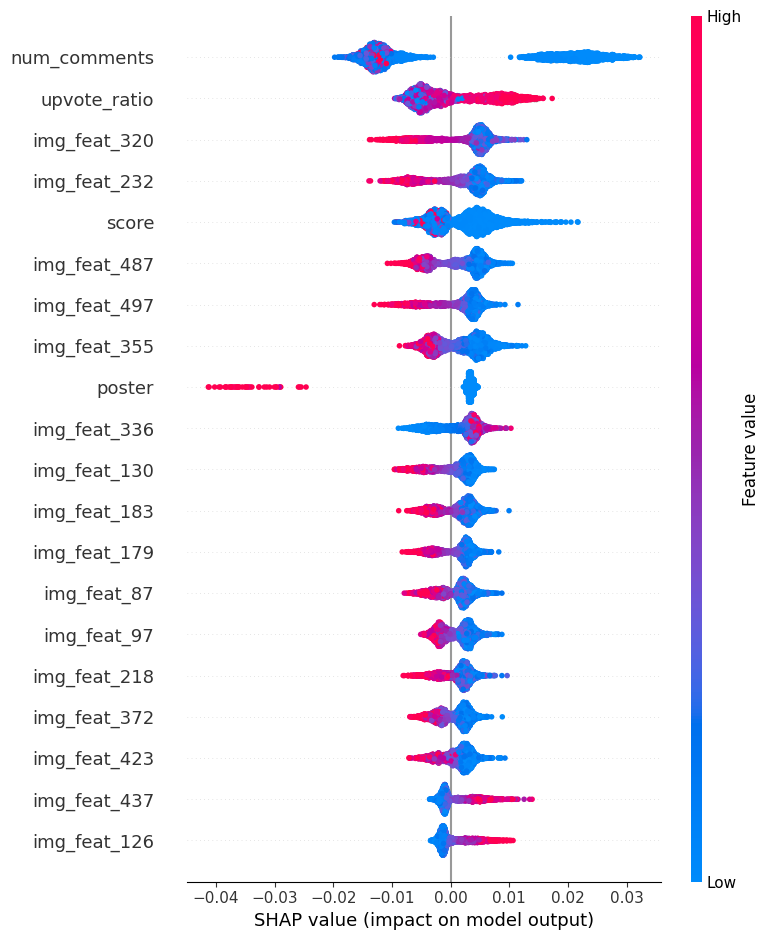

In [38]:
# SHAP summary plot for class 2 (false) 
shap.summary_plot(shap_values[:, :, 2], X_test_df, feature_names=feature_names, show=True)